# ANN layer pruning

This notebook is for pruning individual layers to find the best combination of removing parameters to improve robustness while maintaining performance. 

In [1]:
import tensorflow as tf
import numpy as np
from parana.Model import Model
from parana.Layers import fc_layer
from parana.Layers import softmax_layer
from parana.optimizer import optimizer
from parana.optimizer import adamopt
from parana.parameter_saver import saver
import matplotlib.pyplot as plt
import pickle
from parana.parameter_pruning import lobotomizer
from parana.layer_wiggles import get_mean_activations
from parana.wiggles import get_absolute_values
from parana.parameter_selection import get_k_smallest
from parana.parameter_selection import get_k_max

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

path = 'Path'

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)

# Tensorflow noise varables and operations,
# noise is added at the input of layer 1
noise = tf.Variable(tf.zeros([784]), name='x_noise')
set_zero_noise = tf.assign(noise, tf.zeros([784]))
noise_placeholder = tf.placeholder('float', [784], name = 'noise_placeholder')
assign_noise = tf.assign(noise, noise_placeholder)

class this_model(Model):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.cost_function = 'cross_entropy_l2'
        self.logit_cost_function = 'quadratic_l2'
        self.dropout = 0.7
        self.layers = [fc_layer(inputs=inputs + noise,
                               weight_init = 'xavier',
                               size=1500,
                               weight_decay=0.0001, bias_decay=0.0001)]
        self.layers.append(fc_layer(inputs=self.layers[0].activate, 
                               weight_init = 'xavier',
                               size=800, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs=self.layers[1].activate, 
                               weight_init = 'xavier',
                               size=400, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(softmax_layer(inputs=self.layers[2].activate, 
                                          size=10, 
                                          weight_decay=0.0001, bias_decay=0.0001))
    
X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

mymodel = this_model(X, y)

sess = tf.Session()
# Optimizer for training network
opt = adamopt(sess, 0.00001, mymodel.cost, model =  mymodel)

sess.run(tf.global_variables_initializer())

model_saver = saver(mymodel, sess)

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Training loop
Or load a pre trained model

In [2]:
for i in range(10000):
    batch = mnist.train.next_batch(250)
    opt.min_step(data = {X:batch[0], y:batch[1]})
model_saver.store_parameters()
print ('Finish')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

Finish
0.9661


# Load a pre trained model

In [2]:
model_saver.load_parameters('model.p'.format(path))
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

Parameters loaded from  c:/users/jim/tensorflowtrials/adv_noise/test1.p
0.9865


# Helper functions
Test_function gets arrays of results with incrementally increasing pruning ratios
absvalues prunes based on absolute values, and activationvalues prunes based on mean activation values.

In [4]:
path = 'path'
file_list = ['{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.15.p', '{}adv_class_5_limit_0.1.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_8_limit_0.2.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.2.p']


def test_function(prune_step, layers_list, start_ratio, step_size, steps, file_list):
    accuracies = [[] for i in range(len(file_list)+1)]
    prune_ratio = start_ratio
    #Get accuracies without noise first
    for i in range(steps):
        this_accuracy = mymodel.accuracy(sess, inputs =  mnist.test.images[:1000], labels =  mnist.test.labels[:1000])
        accuracies[0].append(this_accuracy)
        for i in enumerate(file_list):
            noisevector = pickle.load(open(i[1].format(path), 'rb'))
            sess.run(assign_noise, {noise_placeholder: noisevector})
            accuracies[i[0]+1].append(mymodel.accuracy(sess, inputs =  mnist.test.images[:1000], labels =  mnist.test.labels[:1000]))
        prune_step(parameter_ratio = prune_ratio,
                  layers_list = layers_list)
        prune_ratio = prune_ratio + step_size
        sess.run(set_zero_noise)
    model_saver.restore_parameters()
    return accuracies

In [4]:
absvalues = lobotomizer(session = sess,
                          model = mymodel,
                          parameters_list = mymodel.get_weights,
                          wigglyness = get_absolute_values,
                          parameter_selection = get_k_smallest,
                          cost = mymodel.cost,
                          data_function = mnist.train.next_batch,
                          X = X, y = y)
absvalues.get_wigglyness()
print('gotit')

gotit


# Make some plots

C:\Users\Jim\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


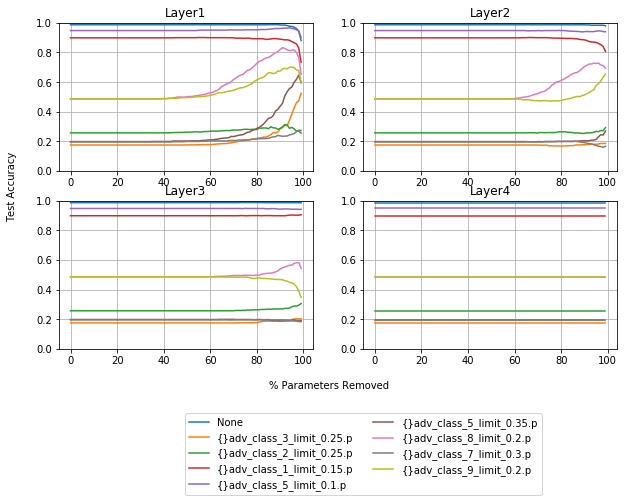

In [34]:
all_accuracies = []
for i in enumerate(mymodel.layers):
    all_accuracies.append(test_function(absvalues.prune_step, layers_list = [i[1]], start_ratio = 0, step_size = 0.01, steps = 100, file_list = file_list))
    absvalues.reset_masks()

label_list = ['None', '{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.15.p', '{}adv_class_5_limit_0.1.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_8_limit_0.2.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.2.p']

fig = plt.figure()

for i in enumerate(all_accuracies):
    for j in range(len(i[1])):
        plt.subplot(221+i[0])
        plt.plot(i[1][j], label = label_list[j])
    plt.title('Layer{}'.format(i[0]+1))
    plt.grid()
    plt.ylim(0,1)
plt.legend(loc=9, bbox_to_anchor=(0, -0.4), ncol=2)
fig.text(0.5, 0.04, '% Parameters Removed', ha='center', va='center')
fig.text(0.06, 0.5, 'Test Accuracy', ha='center', va='center', rotation='vertical')
plt.show()

In [3]:
model_saver.restore_parameters()
activationvalues = lobotomizer(session = sess,
                               model = mymodel,
                               layers_list = mymodel.layers,
                               parameters_list = mymodel.get_weights,
                               wigglyness = get_mean_activations,
                               parameter_selection = get_k_smallest,
                               cost = mymodel.cost,
                               data_function = mnist.train.next_batch,
                               X = X, y = y)
activationvalues.get_wigglyness(iterations = 2000)
print('gotit')

gotit


In [19]:
model_saver.restore_parameters()
path = 'path'
noisevector = pickle.load(open('{}adv_class_3_limit_0.2.p'.format(path), 'rb'))
mymodel.zerodropout
batch = mnist.train.next_batch(10)

#labels
print([np.argmax(i) for i in batch[1]])

outputs = (sess.run(mymodel.logitoutput, {X: batch[0]}))
print('no noise, no pruning', [np.argmax(i) for i in outputs])
print(confidonk(outputs))

noisebatch = np.clip(batch[0] + noisevector, 0,1)

noiseoutput = (sess.run(mymodel.logitoutput, {X: noisebatch}))
print('no pruning, noise output', [np.argmax(i) for i in noiseoutput])
print(confidonk(noiseoutput))
print(mymodel.accuracy(sess, inputs =  np.clip(mnist.test.images + noisevector, 0, 1), labels =  mnist.test.labels))
activationvalues.prune_step(0.83)
noiseoutput = (sess.run(mymodel.logitoutput, {X: noisebatch}))

print('Pruned, noise added', [np.argmax(i) for i in noiseoutput])
print(confidonk(noiseoutput))
print(mymodel.accuracy(sess, inputs =  np.clip(mnist.test.images + noisevector, 0, 1), labels =  mnist.test.labels))

nonoise = (sess.run(mymodel.logitoutput, {X: batch[0]}))
print('pruned nonoise',[np.argmax(i) for i in nonoise])
print(confidonk(nonoise))
print(mymodel.accuracy(sess, inputs =  mnist.test.images, labels =  mnist.test.labels))

[2, 3, 8, 8, 0, 6, 2, 6, 1, 0]
no noise, no pruning [2, 3, 8, 8, 0, 6, 2, 6, 1, 0]
[-428.29672, 1.9862465, 38.87299, 385.3656, -2453.4548, 380.72723, 137.91313, 2.2235796, 216.43541, 83.9961]
no pruning, noise output [2, 3, 3, 8, 0, 6, 2, 3, 3, 0]
[2.9854817, 16.485773, 1.3653436, 1.6171352, 9.17009, 2.1182072, 2.751325, 1.3968164, 1.2404181, 2.1618192]
0.5296
Pruned, noise added [2, 3, 8, 8, 0, 6, 2, 8, 1, 0]
[4.632549, 3.0414958, 2.0775337, 3.8960428, 1.4315202, 11.087147, 6.1699014, 1.8040285, 3.3060322, 5.5145698]
0.8988
pruned nonoise [2, 3, 8, 8, 0, 6, 2, 6, 1, 0]
[21.867933, 1.52671, 11.937016, 14.150101, 1.3265022, 7.4212623, 32.094654, 2.0866885, 37.90199, 12.826509]
0.977


C:\Users\Jim\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


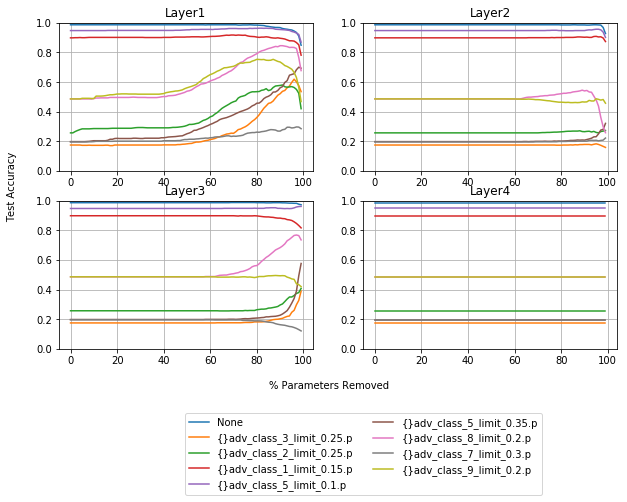

In [36]:
all_activation_accuracies = []
for i in enumerate(mymodel.layers):
    all_activation_accuracies.append(test_function(activationvalues.prune_step, layers_list = [i[1]], start_ratio = 0, step_size = 0.01, steps = 100, file_list = file_list))
    activationvalues.reset_masks()

label_list = ['None', '{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.15.p', '{}adv_class_5_limit_0.1.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_8_limit_0.2.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.2.p']
fig = plt.figure()

for i in enumerate(all_activation_accuracies):
    for j in range(len(i[1])):
        plt.subplot(221+i[0])
        plt.plot(i[1][j], label = label_list[j])
    plt.title('Layer{}'.format(i[0]+1))
    plt.grid()
    plt.ylim(0,1)
plt.legend(loc=9, bbox_to_anchor=(0, -0.4), ncol=2)
fig.text(0.5, 0.04, '% Parameters Removed', ha='center', va='center')
fig.text(0.06, 0.5, 'Test Accuracy', ha='center', va='center', rotation='vertical')
plt.show()

# Try combining for best performance
Time to make a table



In [8]:
nonoise = []
yeenoise = []
sess.run(set_zero_noise)
model_saver.restore_parameters()
path = 'path'
file_list = ['{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.15.p', '{}adv_class_5_limit_0.1.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_8_limit_0.2.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.2.p']

layers = mymodel.layers

nonoise.append(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))
for i in enumerate(file_list):
    noisevector = pickle.load(open(i[1].format(path), 'rb'))
    sess.run(assign_noise, {noise_placeholder: noisevector})
    nonoise.append(mymodel.accuracy(sess, inputs =  mnist.test.images, labels =  mnist.test.labels))

absvalues.prune_step(parameter_ratio = 0.85, layers_list = [layers[0]])
absvalues.prune_step(parameter_ratio = 0.95, layers_list = [layers[1]])
activationvalues.prune_step(parameter_ratio = 0.85, layers_list = [layers[0]])
activationvalues.prune_step(parameter_ratio = 0.95, layers_list = [layers[2]])
sess.run(set_zero_noise)

yeenoise.append(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))
for i in enumerate(file_list):
    noisevector = pickle.load(open(i[1].format(path), 'rb'))
    sess.run(assign_noise, {noise_placeholder: noisevector})
    yeenoise.append(mymodel.accuracy(sess, inputs =  mnist.test.images, labels =  mnist.test.labels))

for i in zip(nonoise, yeenoise):
    print(i)

(0.98650002, 0.94910002)
(0.19930001, 0.72399998)
(0.2764, 0.70840001)
(0.9073, 0.82370001)
(0.95899999, 0.93419999)
(0.2595, 0.56590003)
(0.579, 0.9364)
(0.2263, 0.20110001)
(0.58179998, 0.71380001)
